In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from matplotlib.image import imread
import os
import datetime
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.cm as cm
import keras
from tensorflow import keras
from sklearn.utils import shuffle
from keras.models import Sequential,Model
from keras.layers import MaxPool2D,MaxPooling2D,Flatten,Dense,Conv2D,AveragePooling2D,Activation,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [17]:
classes = ['NORMAL', 'PNEUMONIA', 'COVID19']

class_dict={0:"NORMAL",
           1:"PNEUMONIA",
           2:"COVID19"}
change = {
'NORMAL' : '0',
'PNEUMONIA': '1',
'COVID19' : '2',
}

batch_size=32
epochs=10
image_w=224
image_h=224

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)


In [4]:
#/content/drive/MyDrive/Colab Notebooks/Pneumonia diagnosis system/dataset/Data/train
train_folder = '/kaggle/input/chest-xray-covid19-pneumonia/Data/train'
x, y = [],[]

for category in os.listdir(train_folder):
    for file in os.listdir(os.path.join(train_folder,category)):
        x.append(os.path.join(train_folder,category,file))
        y.append(category)  

train = pd.DataFrame({
    'paths_train':x,
    'class_train':y })
train.head()

,paths_train,class_train
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA


In [5]:
train = shuffle(train, random_state=42)
train.reset_index(drop=True, inplace=True)
train.head()

,paths_train,class_train
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA


In [6]:
train['class_train'] = train['class_train'].map(change)
train

,paths_train,class_train
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,2
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
...,...,...
5139,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
5140,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
5141,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
5142,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0


In [7]:
test_folder = '/kaggle/input/chest-xray-covid19-pneumonia/Data/test'
x2, y2 = [],[]

for category in os.listdir(test_folder):
    for file in os.listdir(os.path.join(test_folder,category)):
        x2.append(os.path.join(test_folder,category,file))
        y2.append(category)  

test = pd.DataFrame({
    'paths_test':x2,
    'class_test':y2 })
test.head()

,paths_test,class_test
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA


In [8]:
test = shuffle(test, random_state=42)
test.reset_index(drop=True, inplace=True)
test.head()

,paths_test,class_test
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA


In [9]:
test['class_test'] = test['class_test'].map(change)
test

,paths_test,class_test
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,2
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,1
...,...,...
1283,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
1284,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
1285,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0
1286,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,0


In [10]:
indexes=[]

def func(x):
    if x[-4:] != '.jpg':
        idx = train[train['paths_train'] == x].index
        indexes.append(idx[0])
        print(idx[0], x)
    return x

train['paths_train'].map(func)

print(train.shape)
train.drop(index=indexes, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)
print(train.shape)

(5144, 2)
(5144, 2)


In [11]:
indexes=[]

def func(x):
    if x[-4:] != '.jpg':
        idx = test[test['paths_test'] == x].index
        indexes.append(idx[0])
        print(idx[0], x)
    return x

test['paths_test'].map(func)

print(test.shape)
test.drop(index=indexes, axis=0, inplace=True)
test.reset_index(drop=True, inplace=True)
print(test.shape)

(1288, 2)
(1288, 2)


In [12]:
for el in range(100, 120):
    path = train.loc[el, 'paths_train']
    img  = cv2.imread(path)
    print(img.shape)

(720, 976, 3)
(1136, 1483, 3)
(880, 1240, 3)
(984, 1216, 3)
(760, 1136, 3)
(768, 1320, 3)
(984, 1328, 3)
(1106, 1555, 3)
(1032, 1613, 3)
(824, 1232, 3)
(1109, 1419, 3)
(976, 1312, 3)
(592, 856, 3)
(1496, 1841, 3)
(616, 992, 3)
(1341, 1798, 3)
(600, 1240, 3)
(672, 1176, 3)
(1299, 1972, 3)
(608, 1072, 3)


In [13]:
for el in range(100, 120):
    path = test.loc[el, 'paths_test']
    img  = cv2.imread(path)
    print(img.shape)

(752, 1152, 3)
(762, 1306, 3)
(864, 1184, 3)
(1178, 1700, 3)
(656, 1242, 3)
(464, 864, 3)
(1603, 1939, 3)
(1171, 1429, 3)
(1320, 1656, 3)
(808, 1064, 3)
(440, 929, 3)
(1152, 1216, 3)
(1304, 1537, 3)
(2000, 2000, 3)
(768, 1192, 3)
(1523, 1746, 3)
(1105, 1326, 3)
(1176, 1472, 3)
(584, 904, 3)
(656, 918, 3)


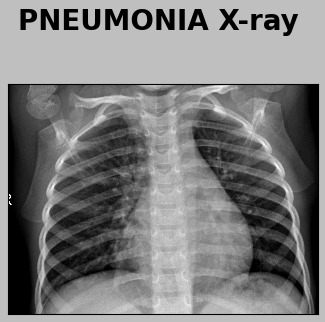

In [93]:
pneumonia_sample = imread("../input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA/PNEUMONIA(100).jpg")
plt.figure(figsize=(5,5))
plt.imshow(pneumonia_sample)
plt.suptitle('PNEUMONIA X-ray', fontsize=25, weight='bold');
plt.xticks([])
plt.yticks([])
plt.show()

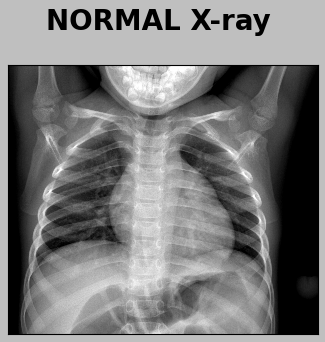

In [94]:
NORMAL_sample = imread("../input/chest-xray-covid19-pneumonia/Data/train/NORMAL/NORMAL(100).jpg")
plt.figure(figsize=(5,5))
plt.imshow(NORMAL_sample)
plt.suptitle('NORMAL X-ray', fontsize=25, weight='bold');
plt.xticks([])
plt.yticks([])
plt.show()

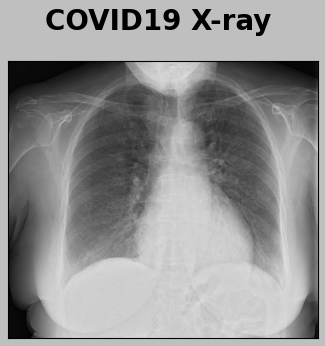

In [95]:
covid_sample = imread("../input/chest-xray-covid19-pneumonia/Data/train/COVID19/COVID19(100).jpg")
plt.figure(figsize=(5,5))
plt.imshow(covid_sample)
plt.suptitle('COVID19 X-ray', fontsize=25, weight='bold');
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
model=Sequential()

model.add(Conv2D(16,(3,3),activation='relu',padding = 'same',input_shape=(image_w,image_h,3),name='conv2d_0'))
model.add(MaxPool2D(2,name='pool_0'))

model.add(Conv2D(32,(3,3),activation='relu',padding = 'same',name='conv2d_9'))
model.add(MaxPool2D(2,name='pool_9'))

model.add(Conv2D(64,(3,3),activation='relu',padding = 'same',name='conv2d_2'))
model.add(MaxPool2D(2,name='pool_2'))

model.add(Conv2D(128,(3,3),activation='relu',padding = 'same',name='conv2d_3'))
model.add(MaxPool2D(2,name='pool_3'))

model.add(Conv2D(256,(3,3),activation='relu',padding = 'same',name='conv2d_5'))
model.add(MaxPool2D(2,name='pool_5'))
model.add(Dropout(0.2,name="dropout_1"))


model.add(Conv2D(512,(3,3),activation='relu',padding = 'same',name='conv2d_6'))
model.add(MaxPool2D(2,name='pool_6'))
model.add(Dropout(0.2,name="dropout_2"))

model.add(Flatten(name='flatten'))

model.add(Dense(1024,activation='relu',name='Dense_0'))
model.add(Dropout(0.2,name="dropout_3"))

model.add(Dense(512,activation='relu',name='Dense_1'))
model.add(Dropout(0.2,name="dropout_4"))


model.add(Dense(3,activation='softmax',name='output'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
pool_9 (MaxPooling2D)        (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)      

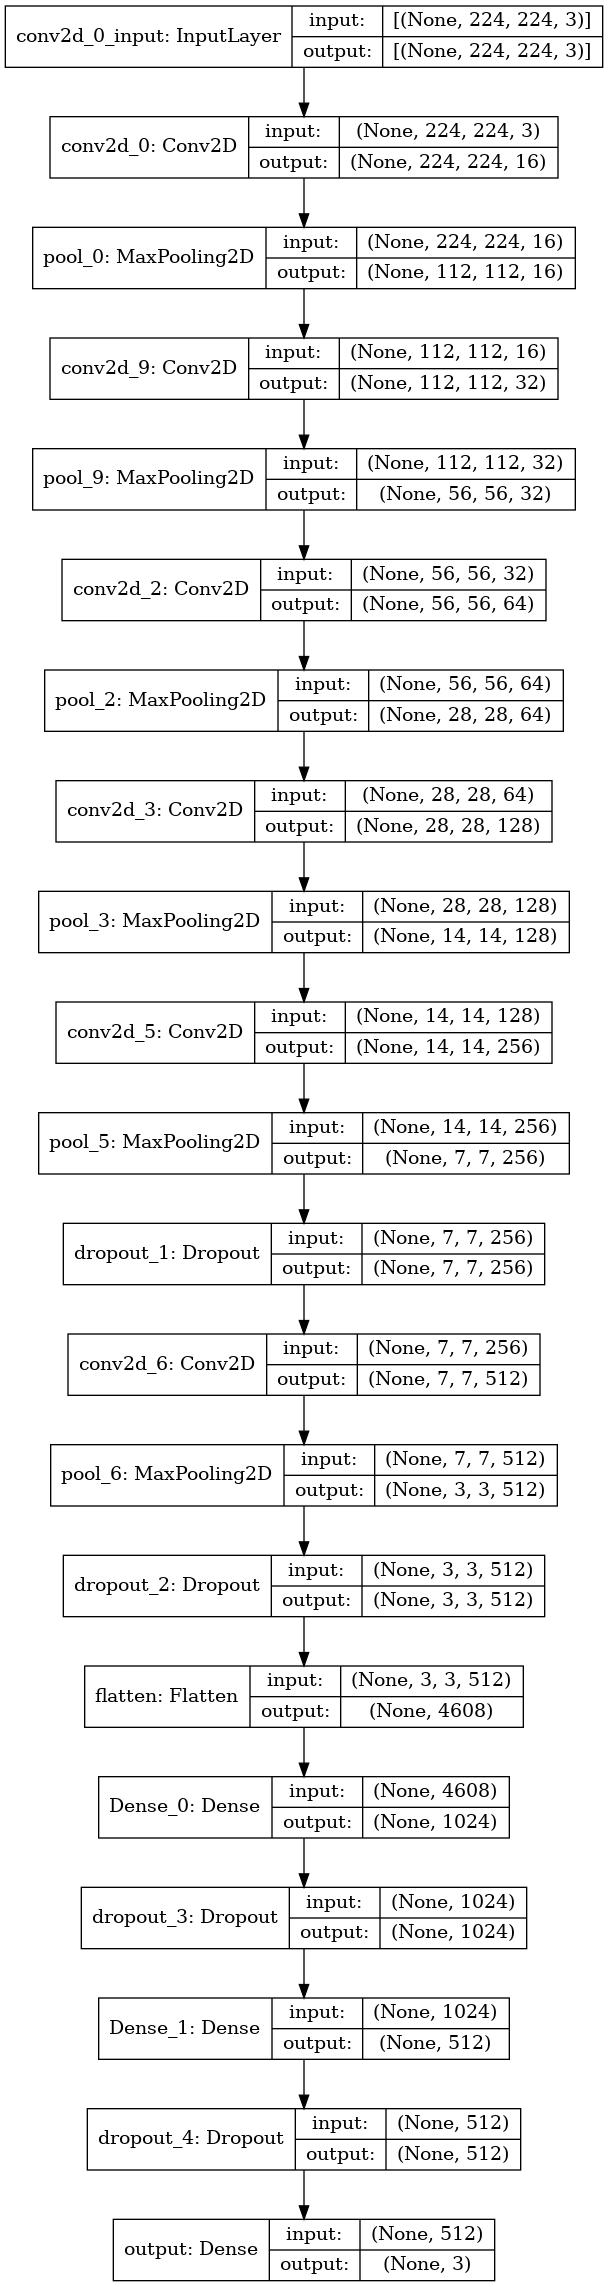

In [21]:
keras.utils.plot_model(model,show_shapes=True)

In [22]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

checkpoint = ModelCheckpoint("loss-{val_loss:0.4f}.h5", monitor="val_loss", verbose=1, 
                             save_best_only=True, save_weights_only=True, mode="min")

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, 
                                            min_lr=1e-7, verbose=1, mode="min")

In [23]:
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, # 0.05
                             brightness_range=[0.9, 1.0],
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=10, 
                            )

test_datagen = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_dataframe(test,
                                        x_col="paths_test",
                                        y_col="class_test",
                                        target_size=(image_w,image_h),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 1288 validated image filenames belonging to 3 classes.


In [24]:
init_time = datetime.datetime.now()
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
for train_idx , val_idx in list(kfold.split(train['paths_train'],train['class_train'])):
    train_df=train.iloc[train_idx]
    val_df=train.iloc[val_idx]


    train_data = datagen.flow_from_dataframe(train_df,
                                            x_col="paths_train",
                                            y_col="class_train",
                                            target_size=(image_w,image_h),
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            num_parallel_calls=AUTOTUNE)


    val_data = test_datagen.flow_from_dataframe(val_df,
                                            x_col="paths_train",
                                            y_col="class_train",
                                            target_size=(image_w,image_h),
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False,
                                            num_parallel_calls=AUTOTUNE)

    train_steps = train_data.samples//batch_size
    valid_steps = val_data.samples//batch_size



    history = model.fit(
        train_data,
        validation_data=val_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=[
                    checkpoint, 
                    early_stopping, 
                    learning_rate_reduction],
        verbose=1,
        )
requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')


Found 4629 validated image filenames belonging to 3 classes.
Found 515 validated image filenames belonging to 3 classes.


2022-12-01 20:04:16.250431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-01 20:04:20.209179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


144/144 [==============================] - 229s 2s/step - loss: 0.7407 - accuracy: 0.6863 - val_loss: 0.4779 - val_accuracy: 0.8340

Epoch 00001: val_loss improved from inf to 0.47795, saving model to loss-0.4779.h5
Epoch 2/10
144/144 [==============================] - 178s 1s/step - loss: 0.3948 - accuracy: 0.8423 - val_loss: 0.3350 - val_accuracy: 0.8984

Epoch 00002: val_loss improved from 0.47795 to 0.33499, saving model to loss-0.3350.h5
Epoch 3/10
144/144 [==============================] - 177s 1s/step - loss: 0.2809 - accuracy: 0.8947 - val_loss: 0.2161 - val_accuracy: 0.9297

Epoch 00003: val_loss improved from 0.33499 to 0.21610, saving model to loss-0.2161.h5
Epoch 4/10
144/144 [==============================] - 175s 1s/step - loss: 0.2603 - accuracy: 0.9034 - val_loss: 0.2260 - val_accuracy: 0.9297

Epoch 00004: val_loss did not improve from 0.21610
Epoch 5/10
144/144 [==============================] - 176s 1s/step - loss: 0.2435 - accuracy: 0.9102 - val_loss: 0.1981 - val_a

In [25]:
history_df = pd.DataFrame(history.history)
min_loss=history_df['val_loss'].min()
print("Minimum Validation Loss: {:0.4f}".format(min_loss));

Minimum Validation Loss: 0.0483


In [26]:
#model.load_weights('loss-{:0.4f}.h5'.format(min_loss))

test_steps = test_data.samples // batch_size

test_loss, test_acc = model.evaluate(test_data,steps=test_steps)


40/40 [==============================] - 41s 1s/step - loss: 0.1264 - accuracy: 0.9570


In [27]:
print('\naccuracy: {}%'.format(round(test_acc*100,2)), '\nloss: {:0.4f}'.format(test_loss))


accuracy: 95.7% 
loss: 0.1264


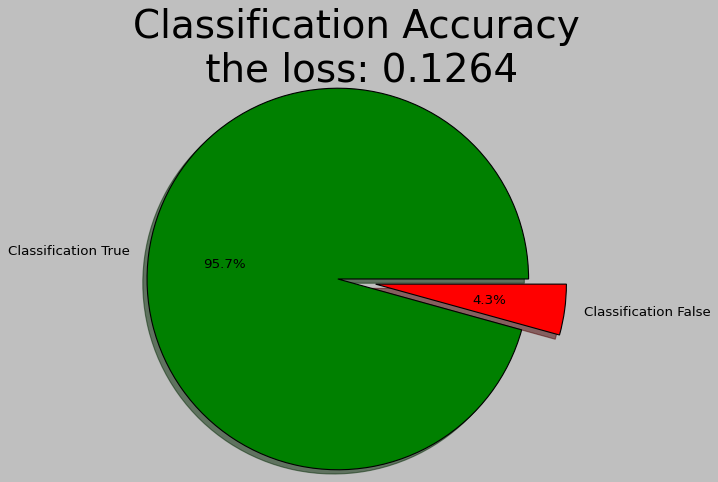

In [28]:
plt.style.use('classic')
plt.pie([test_acc,1-test_acc],labels=('Classification True','Classification False')
        ,explode=[0.1,0.1],autopct="%1.1f%%",shadow=True,colors=['green','red'])
plt.axis('equal')
plt.title('Classification Accuracy\n the loss: {:0.4f}'.format(test_loss),fontsize=35)
plt.show()

In [29]:
model.save('CNN2.h5')

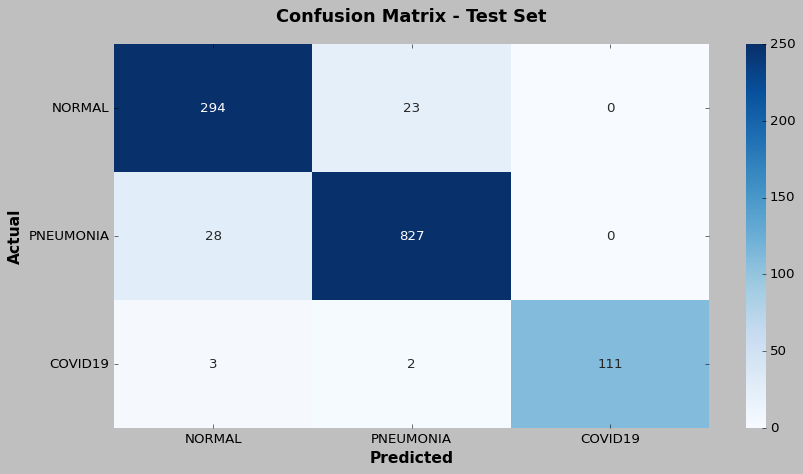

In [30]:
y_pred=model.predict(test_data)
predictions=np.array(list(map(lambda x:np.argmax(x),y_pred)))
y_true=test_data.classes
CMatrix=pd.DataFrame(confusion_matrix(y_true,predictions),columns=classes,index=classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [31]:
print(y_true[:10])
print(predictions[:10])

[0, 2, 1, 1, 1, 1, 1, 0, 1, 1]
[0 2 1 1 1 1 1 0 0 1]


In [32]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       317
           1       0.97      0.97      0.97       855
           2       1.00      0.96      0.98       116

    accuracy                           0.96      1288
   macro avg       0.96      0.95      0.95      1288
weighted avg       0.96      0.96      0.96      1288



In [40]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'PNEUMONIA' in file_path:
        true_class = 'PNEUMONIA'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss


# https://keras.io/examples/vision/grad_cam/
def superimposed_img(img, heatmap,pred_class,pred_prob_final):

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.5 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM

    plt.matshow(superimposed_img)

    plt.xticks([])
    plt.yticks([])

    plt.title('Predict: '+str(pred_class)+'\n Confidence: '+str(pred_prob_final)+"%",fontsize=25, weight='bold');

    plt.show()




In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
pool_9 (MaxPooling2D)        (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)      

In [39]:
last_conv_layer_name = "conv2d_6"
classifier_layer_names = [
    'pool_6',
    'dropout_2',
    "flatten",
    "Dense_0",
    "dropout_3",
    "Dense_1",
    'dropout_4'

]

In [41]:
def img_rgb(img_test_path):

    test_image=cv2.imread(img_test_path,cv2.IMREAD_COLOR)
    test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    test_image=cv2.resize(test_image,(224,224))
    
    return test_image 


def imshow(img_test_path):
    
    img_test_list=list(img_test_path.split('/'))
    test_image=img_rgb(img_test_path)
    plt.xticks([])
    plt.yticks([])
    plt.title('the Actual Class: :{}'.format(img_test_list[-2]),fontsize=25)
    plt.imshow(test_image)
    plt.show()
    

    
def show_visual_img(img_test_path):
    
    test_image=img_rgb(img_test_path)
    
    test_image=np.expand_dims(test_image,axis=0)
    
    img=img_rgb(img_test_path)
    
    img=np.expand_dims(img,axis=0)

    img=img/255.0
    
    score = model.predict(img)


    pred_class_num=np.argmax(score)
    print(pred_class_num)
    pred_class=class_dict[pred_class_num]
    print(pred_class)

    pred_prob=np.max(score) * 100
    print(pred_prob)
    pred_prob_final=round(pred_prob,2)

    heatmap, top_index = make_gradcam_heatmap(test_image, 
                                              model, 
                                              last_conv_layer_name, 
                                              classifier_layer_names)

    superimposed_img(test_image[0], heatmap,pred_class,pred_prob_final)
    
    


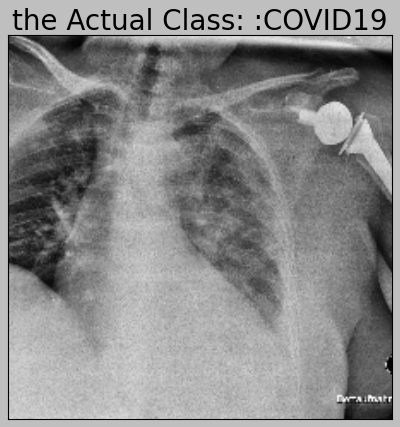

2
COVID19
99.38003420829773


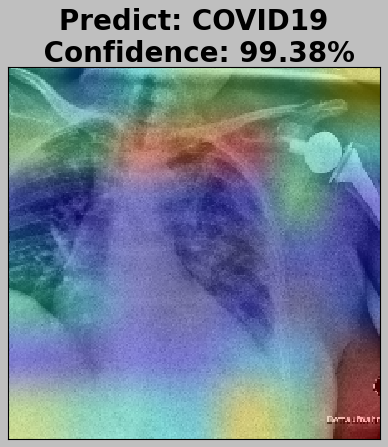

In [49]:
img_test_path='/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(467).jpg'
imshow(img_test_path)
show_visual_img(img_test_path)

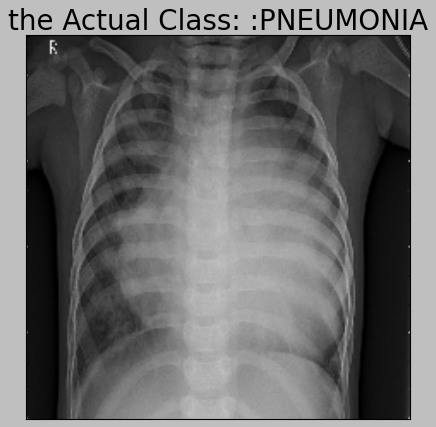

1
PNEUMONIA
99.99921321868896


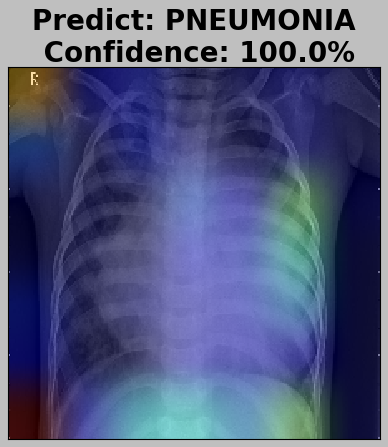

In [50]:
img_test_path='/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3420).jpg'
imshow(img_test_path)
show_visual_img(img_test_path)

In [45]:
from glob import glob

test_paths = np.array(glob('/kaggle/input/chest-xray-covid19-pneumonia/Data/test' + '/*/*.jpg'))

ids = np.random.choice(np.arange(len(test_paths)), size=32)


samples = test_paths[ids]

In [46]:
im_test = []
c = 0
for img in samples:
    c = c + 1
    img_path = img
    img_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_arr = cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_arr, (224, 224))
    img_arr = img_arr / 255.0
    im_test.append(img_arr)

    
im_test = np.array(im_test).reshape(-1, 224, 224,3)
im_pred = model.predict(im_test)

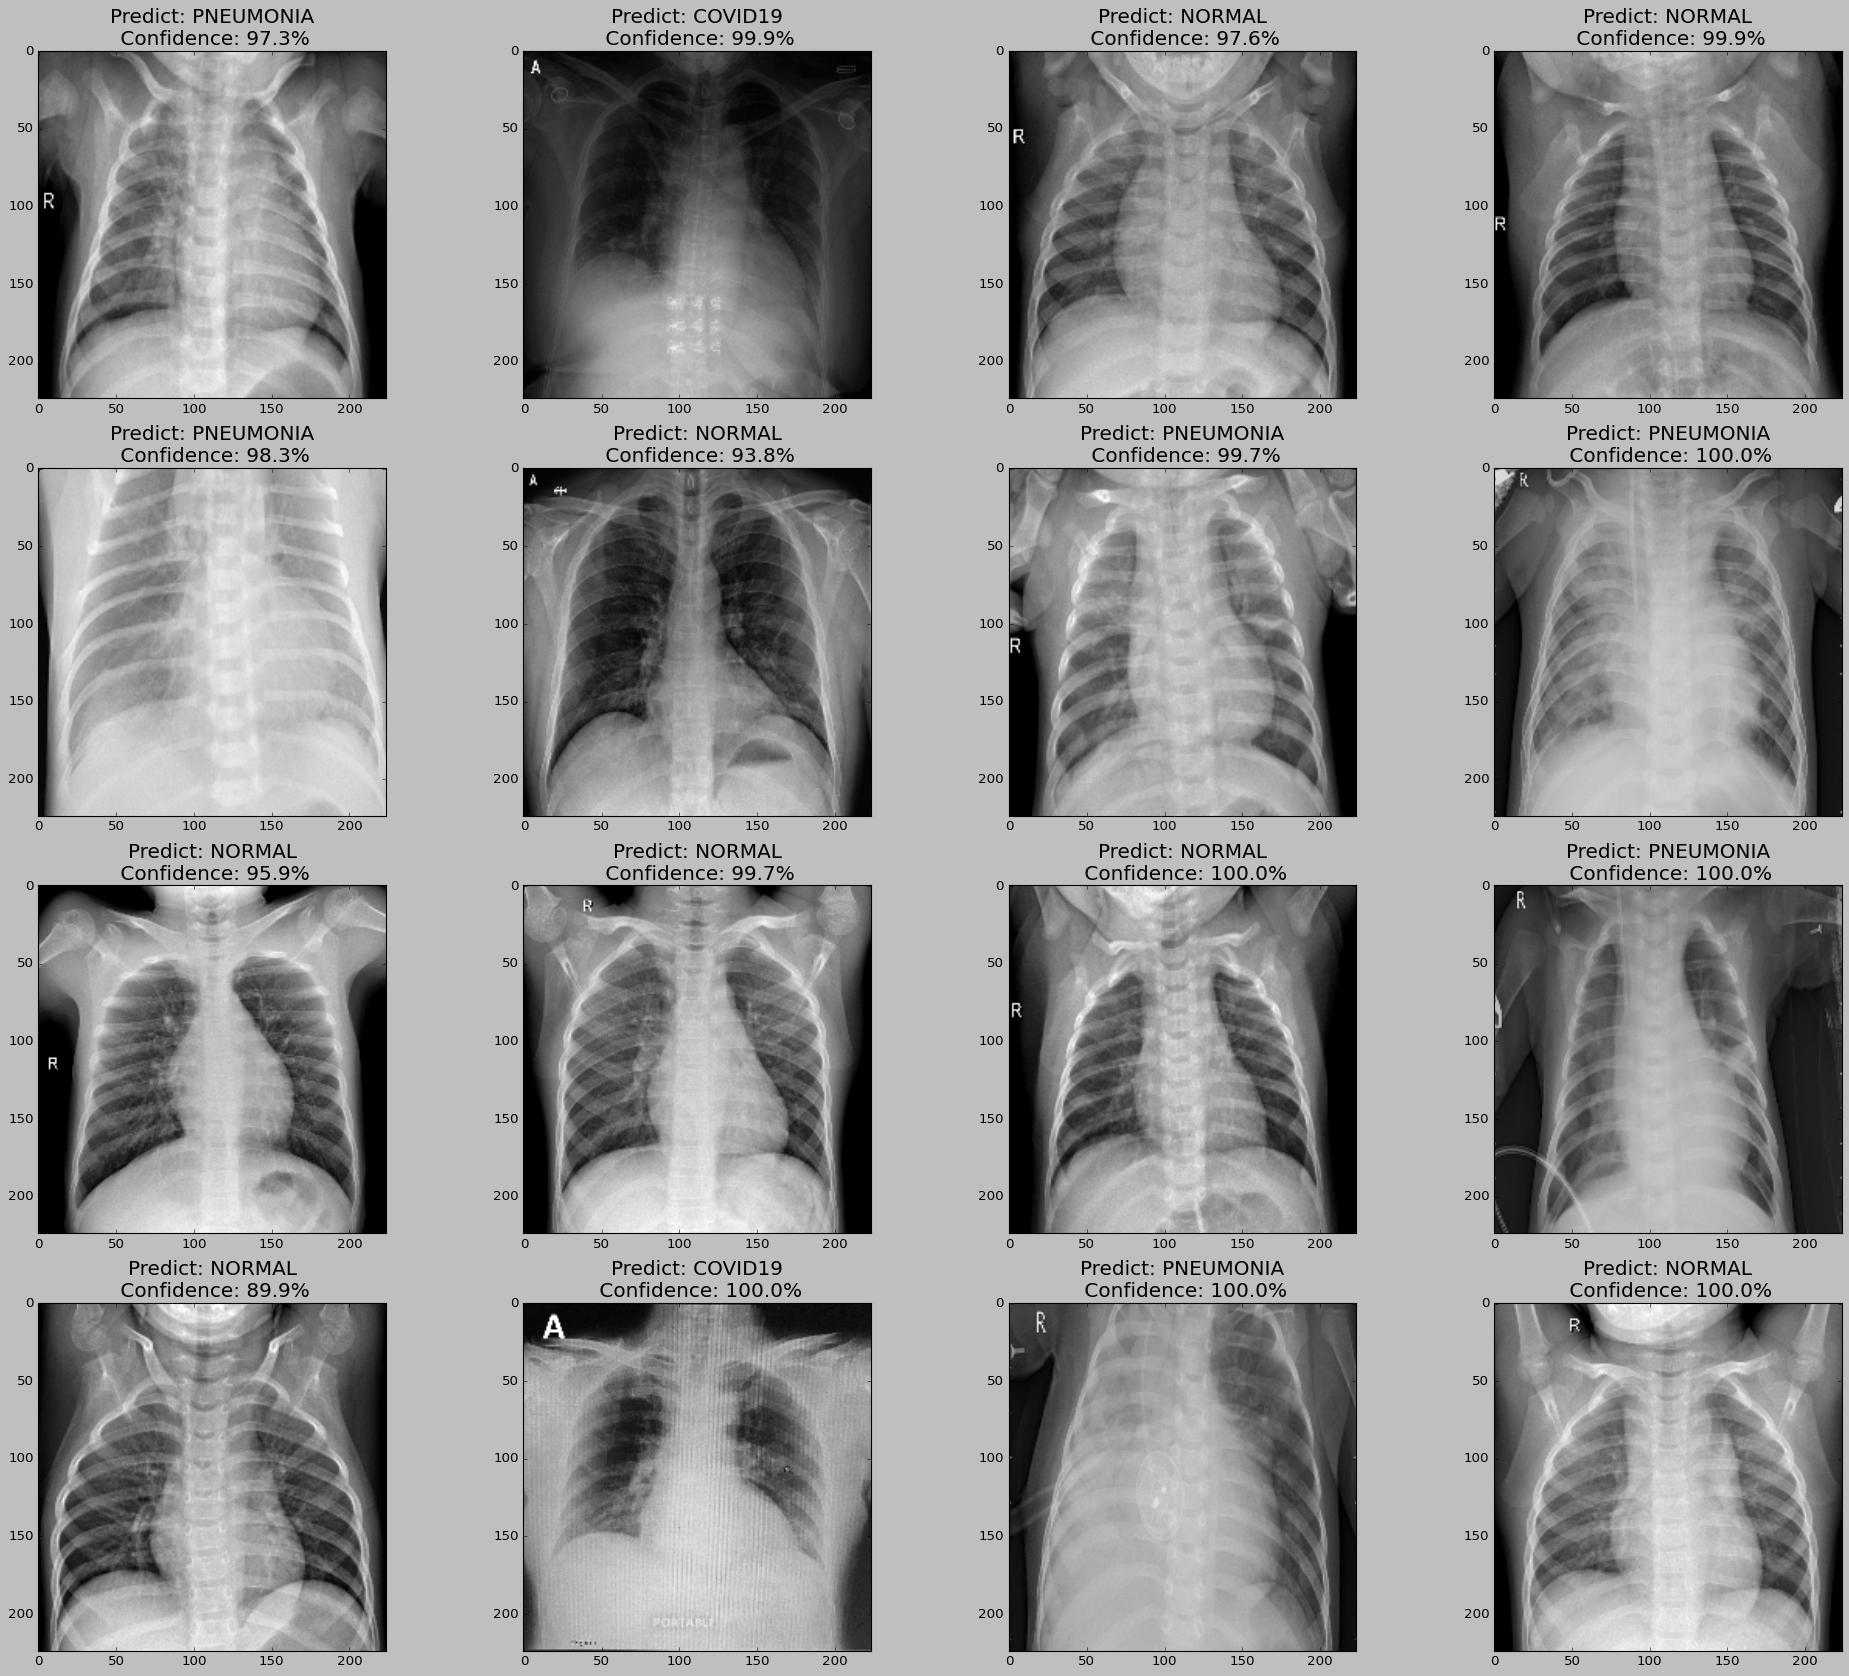

In [47]:
fig , ax = plt.subplots(4, 4, figsize=(30, 25))


for i, axis in enumerate(ax.flat):
    axis.imshow(im_test[i][:, :, 0],cmap='gray')
    pred_class = im_pred[i].argmax()
    pred_prob = im_pred[i].max() * 100
    

    axis.set_title(f'Predict: {class_dict[pred_class]}\n Confidence: {pred_prob:.1f}%', fontsize=18)